fun trick to get imports to work properly

In [8]:
import sys
sys.path.insert(0, '..')

In [9]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data loading

In [10]:
ddir = '../data/MAST_2024-07-03T0023-1/'

#fname = ddir + 'HST/n9nk01010/n9nk01010_mos.fits'
#fname = ddir + 'HST/n8yj02010/n8yj02010_mos.fits'
#fname = ddir + 'HST/n9nk14010/n9nk14010_mos.fits'

fname = ddir + 'HST/n9nk01020/n9nk01020_mos.fits'
#fname = ddir + 'HST/n9nk14020/n9nk14020_mos.fits'
#fname = ddir + 'HST/n8yj65020/n8yj65020_mos.fits'


ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
fname = ddir + 'HST/n8ku01050_mos.fits'


data = fits.getdata(fname, ext=1)
err = fits.getdata(fname, ext=2)

image_hdr = fits.getheader(fname, ext=1) # this is the header for just the image in particular

# rather than manipulate WCS coordinates ourselves, can use https://docs.astropy.org/en/stable/wcs/
w = WCS(image_hdr)

y,x = numpy.unravel_index(numpy.argmax(data),data.shape)
centre = SkyCoord(w.pixel_to_world(x,y), unit='deg') # astropy wants to keep track of units

wid = 64#156

# use fits_cut because we want WCS metadata cropped appropriately
#cuts = fits_cut(fname, centre, 64, single_outfile=True, memory_only=True)
#cutout = cuts[0]
#cropped = cutout[1].data
#cropped_image_hdr = cutout[1].header

cropped = Cutout2D(data, centre, wid, wcs=w).data
err_cropped = Cutout2D(err, centre, wid, wcs=w).data

cropped_data = np.asarray(cropped, dtype=float)#+0.1#.clip(min=0)
cropped_err = np.asarray(err_cropped, dtype=float)

cropped_err = np.where(cropped_err==0.0, 1e10,cropped_err)

construct model

In [11]:
# F170M

wavels = 1e-6 * np.linspace(1.60, 1.80, 20)

# F110W
#wavels = 1e-6 * np.linspace(0.8, 1.35, 40)

weights = np.concatenate([np.linspace(0., 1., 10), np.linspace(1., 0., 10)])

source = dl.PointSource(
    wavelengths=wavels,
    #spectrum=dl.Spectrum(wavels, weights),
    flux = 50000
)

oversample = 2

optics = dl.AngularOpticalSystem(
    512,
    2.4,
    [
        dl.CompoundAperture([
            ("main_aperture",HSTMainAperture(softening=0.01)),
            ("cold_mask",NICMOSColdMask(softening=0.01))
        ],normalise=True),
        dl.AberratedAperture(
            dl.layers.CircularAperture(1.2),
            noll_inds=np.asarray([4,5,6,7,8,9,10,11]),
            #coefficients = np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9
        )
    ],
    wid,
    0.043,
    oversample
)

detector = dl.LayeredDetector(
    [
        ("detector_response", ApplyNonlinearity(coefficients=np.zeros(3), order = 5)),
        ("constant", dl.layers.AddConstant(value=0.0)),
        ("pixel_response",dl.layers.ApplyPixelResponse(np.ones((wid*oversample,wid*oversample)))),
        #("jitter", dl.layers.ApplyJitter(sigma=0.1)),
        ("downsample", dl.layers.Downsample(oversample))
     ]
)


telescope = dl.Telescope(
    optics,
    source,
    detector
)

gradient time

In [12]:
paths = [
    "flux",
    "position",
    "cold_mask.transformation.translation", "cold_mask.transformation.rotation",
    "AberratedAperture.coefficients",
    "cold_mask.outer.radius", "cold_mask.secondary.radius",
    #"main_aperture.mirror.radius", "main_aperture.secondary.radius",
    #"main_aperture.pad_1.translation",
    #"main_aperture.pad_2.translation",
    #"main_aperture.pad_3.translation",
    #"cold_mask.pad_1.translation",
    #"cold_mask.pad_2.translation",
    #"cold_mask.pad_3.translation",
    #"cold_mask.pad_1.rotation",
    #"cold_mask.pad_2.rotation",
    #"cold_mask.pad_3.rotation",
    "cold_mask.pad_1.width",
    "cold_mask.pad_2.width",
    "cold_mask.pad_3.width",
    #"cold_mask.pad_1.height",
    #"cold_mask.pad_2.height",
    #"cold_mask.pad_3.height",
    "cold_mask.spider.width",
    "constant.value",
    "detector_response.coefficients",
    "optics.psf_pixel_scale"
    #"jitter.sigma",
    #"pixel_response.pixel_response"
]

groups = [
    "flux", "position",
    "cold_mask.transformation.translation", "cold_mask.transformation.rotation",
    "AberratedAperture.coefficients",
    [
        "cold_mask.outer.radius",
        "cold_mask.secondary.radius",
    #    "main_aperture.mirror.radius",
    #    "main_aperture.secondary.radius"
    ],
    #[
    #    "main_aperture.pad_1.translation",
    #    "main_aperture.pad_2.translation",
    #    "main_aperture.pad_3.translation",
    #    "cold_mask.pad_1.translation",
    #    "cold_mask.pad_2.translation",
    #    "cold_mask.pad_3.translation"
    #],
    #[
    #    "cold_mask.pad_1.rotation",
    #    "cold_mask.pad_2.rotation",
    #    "cold_mask.pad_3.rotation"
    #],
    #[
    #    "cold_mask.pad_1.width",
    #    "cold_mask.pad_2.width",
    #    "cold_mask.pad_3.width",
    #    "cold_mask.pad_1.height",
    #    "cold_mask.pad_2.height",
    #    "cold_mask.pad_3.height",
    #],
    "cold_mask.spider.width",
    "constant.value",
    "detector_response.coefficients",
    "optics.psf_pixel_scale",
    #"jitter.sigma"
    #"pixel_response.pixel_response"
]

@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(model,data):
    img, err = data
    psf = model.model()
    return -jsp.stats.norm.logpdf(psf, img, err).sum()

le optimisation

In [13]:
pixel_opt = optax.piecewise_constant_schedule(init_value=1e-2*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})

optimisers = [
    optax.adam(1e4),
    optax.adam(1e-7),
    optax.adam(1e-3),
    optax.adam(5e-4),
    optax.adam(1e-10),
    optax.adam(0e-3),
    #optax.adam(1e-3),
    #optax.adam(1e-4),
    #optax.adam(1e-3),
    optax.adam(0e-2),
    optax.adam(0e-3),
    optax.adam(0e-10),
    optax.adam(1e-2)
    #optax.adam(1e-2)
    #optax.adam(pixel_opt)
]

optim, opt_state = zdx.get_optimiser(
    telescope, groups, optimisers
)

losses, models = [], []
for i in tqdm(range(100)):
    loss, grads = loss_fn(telescope,(cropped_data,cropped_err))
    updates, opt_state = optim.update(grads, opt_state)
    telescope = zdx.apply_updates(telescope, updates)

    models.append(telescope)
    losses.append(loss)


  0%|          | 0/100 [00:00<?, ?it/s]

7.151118e+09, 6.699507e+08
flux 178147.06
position [-1.1923117e-08 -1.2629506e-07]
cold_mask.transformation.translation [-0.04793333 -0.04350151]
cold_mask.transformation.rotation 0.7832506
AberratedAperture.coefficients [-1.0200415e-09 -6.0694898e-09  9.8014941e-10  4.1867740e-09
 -6.7307138e-09  4.5284887e-09 -5.7770650e-09  2.6523996e-09]
cold_mask.outer.radius 0.955
cold_mask.secondary.radius 0.372
cold_mask.spider.width 0.077
constant.value 0.0
detector_response.coefficients [0. 0. 0.]
optics.psf_pixel_scale 0.051837917


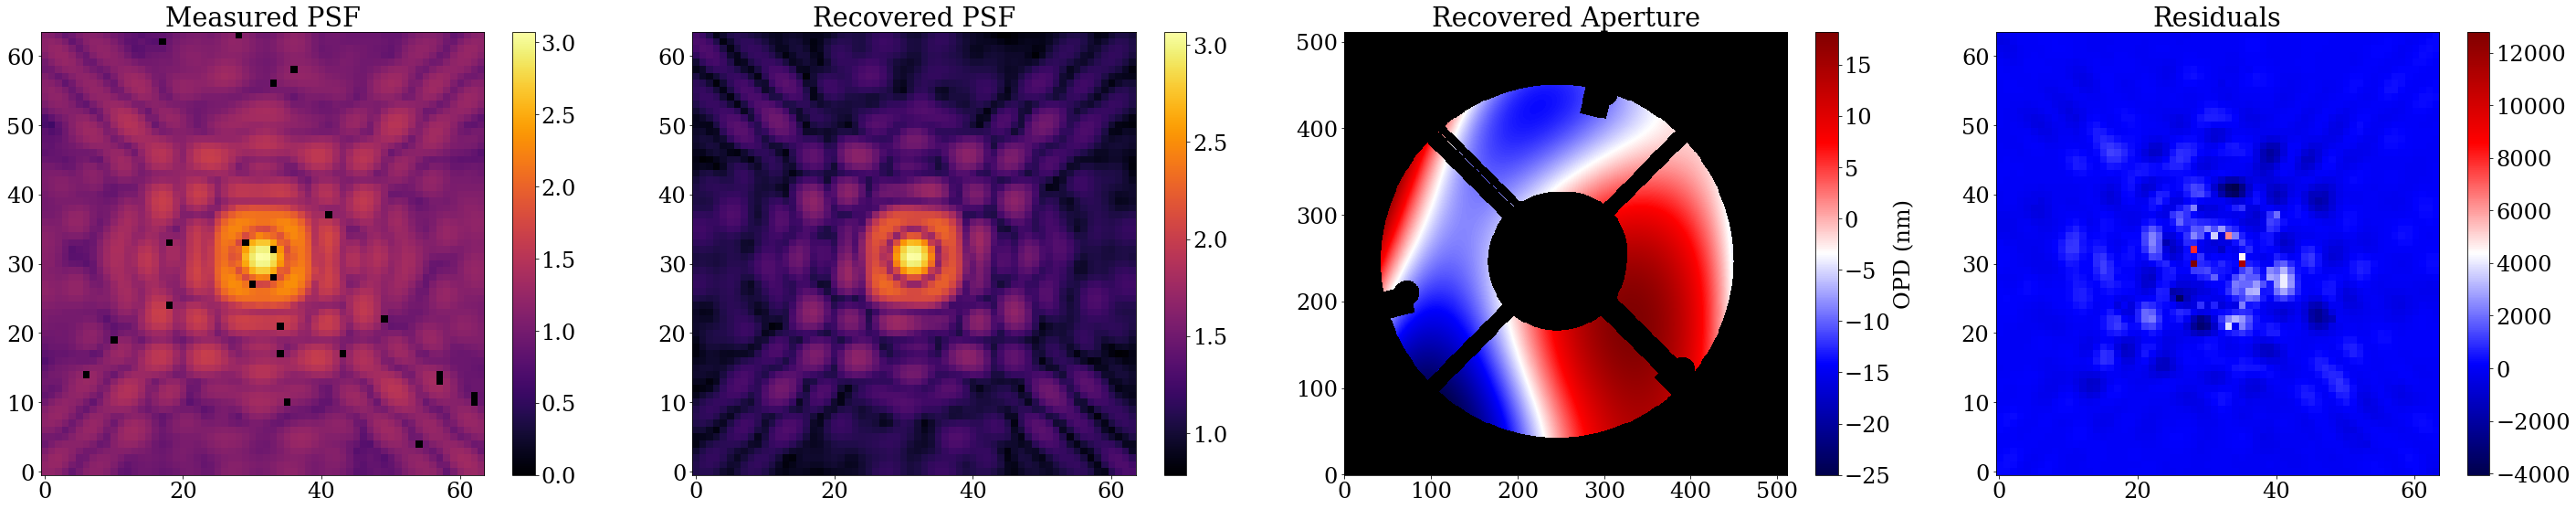

In [14]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

#print(telescope.get(paths))

for g in groups:
    if type(g) == list:
        for s in g:
            print(s, telescope.get(s))
    else:
        print(g, telescope.get(g))

#plt.figure(figsize=(10, 4))


fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

coords = dlu.pixel_coords(512, 2.4)
cd=axs[0].imshow((cropped_data)**0.125)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow((telescope.model())**0.125)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)
support = telescope.optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = telescope.optics.AberratedAperture.eval_basis(coords)
apt =axs[2].imshow(support_mask*opd*1e9,cmap=cmap)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid=axs[3].imshow((cropped_data - telescope.model())/cropped_err, cmap='seismic')
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)
